In [13]:
import sys
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.io

from collections import Counter

In [2]:
debug = True
data_type = 'meditation' # 'mind-wandering'

## Data loading

In [3]:
dtype_names = ["HT", "SNY", "VIP", "CTR"]

def load_data(name):
    return scipy.io.loadmat('../data/Meditation/{}.mat'.format(name))

if debug:
    all_mats = {}
    for mat in dtype_names:
        all_mats[mat] = load_data(mat)
        #print(ht_mat.keys())
        print(mat, all_mats[mat][mat].shape)

HT (16, 3)
SNY (16, 3)
VIP (16, 3)
CTR (16, 2)


In [5]:
all_mats['HT']['HT'][0].shape, all_mats['CTR']['CTR'][0].shape

((3,), (2,))

In [9]:
# 0th subject of control, has only breathing-focus and mind-wandering (they cannot meditate :). 
all_mats['CTR']['CTR'][0][1].shape

(64, 130688)

16x3 denotes data of 16 subjects for three exercises: breathing, meditation, and mind-wandering/thinking. For the CTR, i.e. control group, the 16x2 data is present only for breathing and meditation.

In [10]:
def get_data_stats():
    ht_mat = all_mats['HT']
    print("Shapes of meditation data for HT for breathing, mind-wandering, and meditation. 64 denotes the number of EEG channels.")
    print(ht_mat['HT'][0,0].shape, ht_mat['HT'][0,1].shape, ht_mat['HT'][0,2].shape)
    print(np.min(ht_mat['HT'][0,0][0]), np.max(ht_mat['HT'][0,0][0]), np.mean(ht_mat['HT'][0,0][0]))
    
    
if debug:
    get_data_stats()

Shapes of meditation data for HT for breathing, mind-wandering, and meditation. 64 denotes the number of EEG channels.
(64, 131584) (64, 136192) (64, 115328)
-40.85619 43.898754 -0.36777097


## Analyze the stats across all channels for subjects practising different types of meditation techniques 

In [22]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color="#636363", linewidth=2)


def plot_channelwise_boxplot(all_mats, data_type='mind-wandering'):
    fig, axs = plt.subplots(8, 8, figsize=(16, 32))
    boxprops = dict(linewidth=2)
    bplot_colors = ['#D7191C', '#F8B100', '#2C7BB6', '#B3C302']

    for channelidx in range(0, 64):
        rowidx = (channelidx//8)
        colidx = channelidx%8
        for _, med_tech in enumerate(dtype_names):
            if data_type == 'mind-wandering':
                subj_data = all_mats[med_tech][med_tech][:,1]
            elif data_type == 'meditation':
                if med_tech == 'CTR':
                    subj_data = all_mats[med_tech][med_tech][:,0]
                else:
                    subj_data = all_mats[med_tech][med_tech][:,2]

            channel_spec_data = np.array([])
            for subj in subj_data:
                channel_spec_data = np.append(channel_spec_data, subj[channelidx,:])
            bpl = axs[rowidx, colidx].boxplot(channel_spec_data, positions=[0+_], sym='', widths=0.6, boxprops=boxprops)
            set_box_color(bpl, bplot_colors[_])
            axs[rowidx, colidx].set_title('ChannelId: {}'.format(channelidx+1))
            axs[rowidx, colidx].sharex(axs[0, 0])
            axs[rowidx, colidx].sharey(axs[0, 0])

    for ax in fig.get_axes():
        ax.label_outer();
    plt.xticks(range(0, len(dtype_names)), dtype_names);

    #fig.suptitle('Boxplots for each channel across the four groups: HT, SNY, VIP, CTR')

    plt.savefig("figures/{}_channelwise_boxplot_wo_outliers.png".format(data_type))

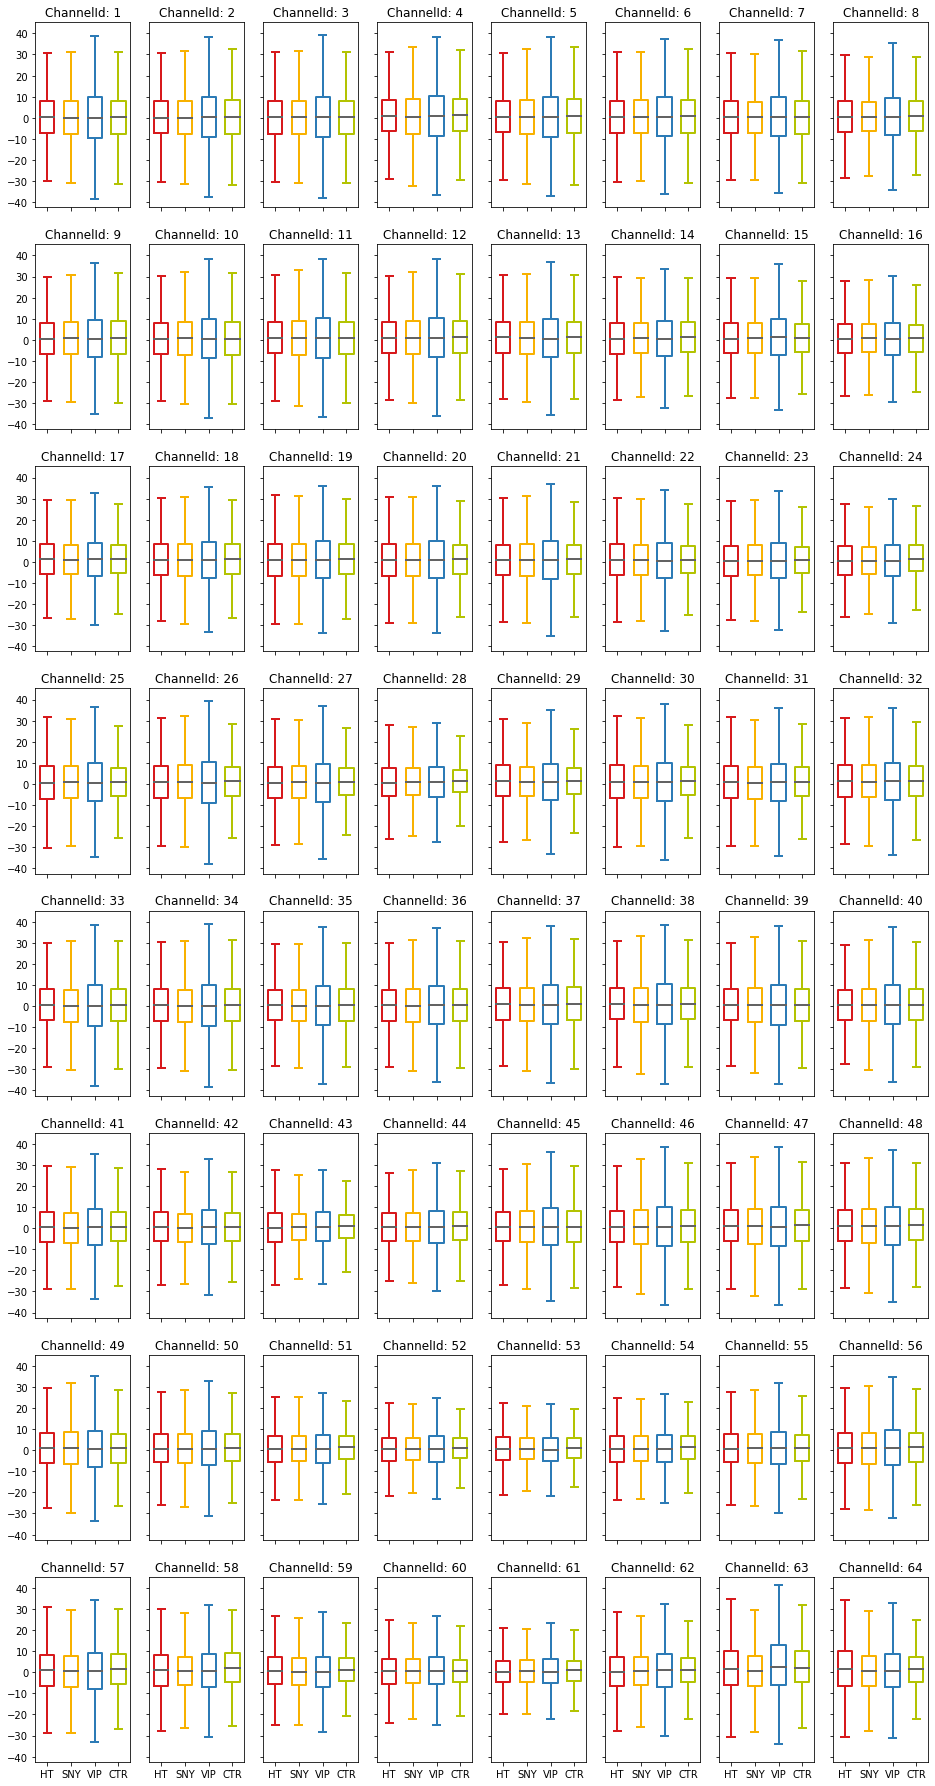

In [17]:
plot_channelwise_boxplot(all_mats, data_type='mind-wandering')

Similar results indicate that there is no specific channel which is significantly different for a specific group (meditaiton traditions HT, SYN, VIP, or the CTR)

Channels 1-16 show similar trends. From channel 17 onwards, more differences in the range of the amplitudes is observed. For most channels, maximum variation is observed in VIP tradition. The minimum range is observed in the CTR group across most channels.

However, when we plot the outliers, we see interesting patterns in the channel ids 18, 21, 26 for the VIP group, and 25, 26, 27, and 29 for the CTR group.

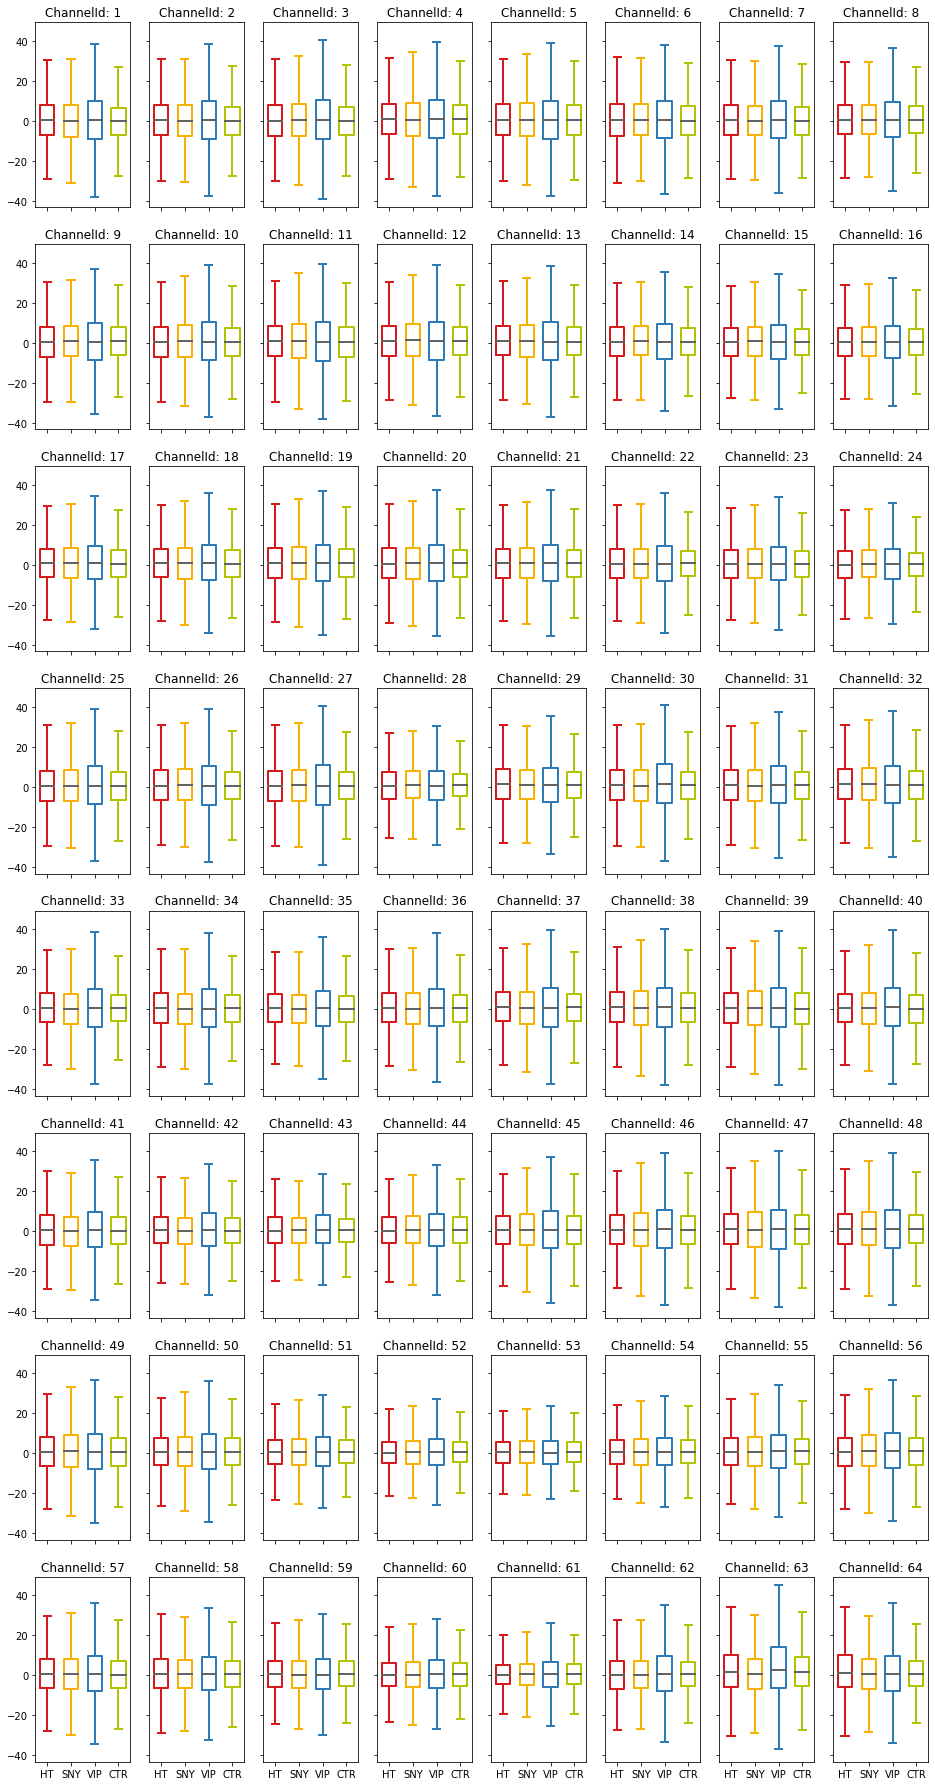

In [23]:
plot_channelwise_boxplot(all_mats, data_type='meditation')

Data type:meditation Global min timestep sizes: {'HT': 104223, 'SNY': 78950, 'VIP': 105216, 'CTR': 117120} for group-sub {'HT': ['HT', 11], 'SNY': ['SNY', 5], 'VIP': ['VIP', 15], 'CTR': ['CTR', 1]}
Data type:mind-wandering Global min timestep sizes: {'HT': 118656, 'SNY': 63616, 'VIP': 114688, 'CTR': 110976} for group-sub {'HT': ['HT', 8], 'SNY': ['SNY', 8], 'VIP': ['VIP', 12], 'CTR': ['CTR', 11]}


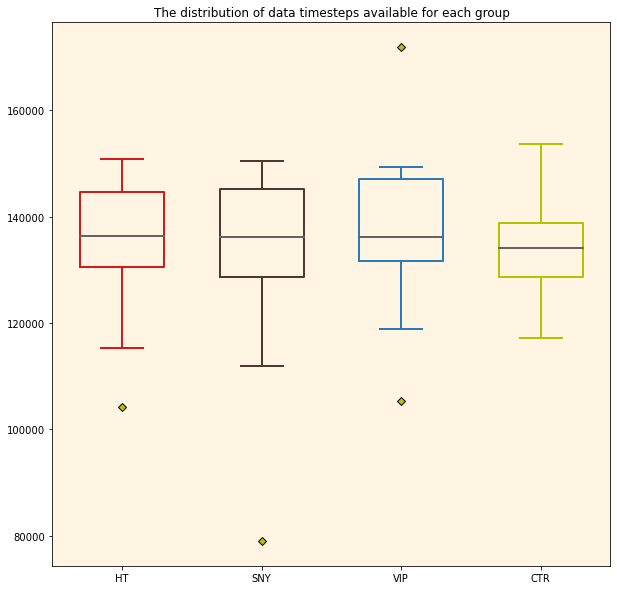

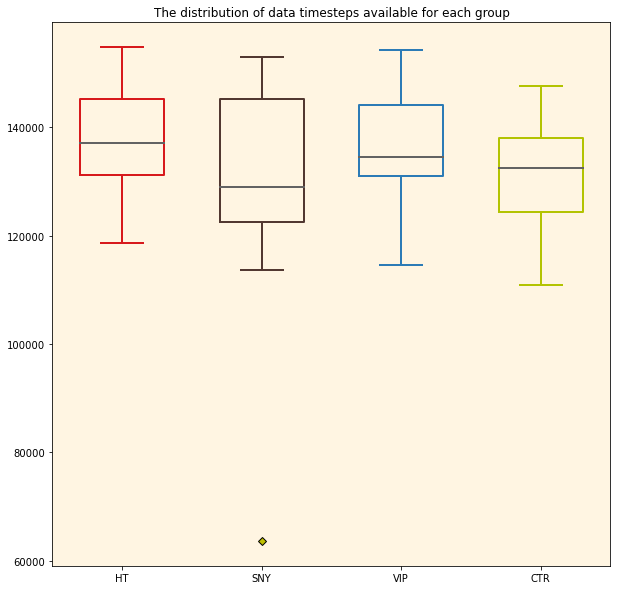

In [26]:
def truncate_to_equal_time_steps(all_mats, data_type='mind-wandering'):
    global_min = {med: sys.maxsize for med in dtype_names}
    global_min_args = {med: [] for med in dtype_names}
    group_sizes = {med: [] for med in dtype_names}
    
    for med in dtype_names:
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            # if data_type == 'mind-wandering':
            #     if subj_idx == 8 and med == 'SNY':
            #         continue
            # elif data_type == 'meditation':
            #     if (subj_idx ==  11 and med == 'HT') or (subj_idx ==  5 and med == 'SNY') or (subj_idx ==  15 and med == 'VIP'):
            #         continue
            if data_type == 'mind-wandering':
                sub_min = subj_data[1].shape[1]
            elif data_type == 'meditation':
                if med == 'CTR':
                    sub_min = subj_data[0].shape[1]
                else:
                    sub_min = subj_data[2].shape[1]
            group_sizes[med].append(sub_min)
            if sub_min < global_min[med]:
                global_min[med] = sub_min
                global_min_args[med] = [med, subj_idx]
    return group_sizes, global_min, global_min_args


def plot_timesteps_per_group(group_sizes, data_type):
    
    fig = plt.figure(figsize=(10, 10))
    plt.rcParams['axes.facecolor'] = '#FFF5E2'
    boxprops = dict(linewidth=2)
    bplot_colors = ['#D7191C', '#523831', '#2C7BB6', '#B3C302']
    green_diamond = dict(markerfacecolor='y', marker='D')
    
    for _, med in enumerate(dtype_names):
        bpl = plt.boxplot(group_sizes[med], positions=[0+_], widths=0.6, boxprops=boxprops, flierprops=green_diamond)
        set_box_color(bpl, bplot_colors[_])
    plt.xticks(range(0, len(dtype_names)), dtype_names);
    plt.title('The distribution of data timesteps available for each group')
    
    plt.savefig("figures/{}_group_wise_timesteps.png".format(data_type))
            
if debug:
    for data_type in ['meditation', 'mind-wandering']:
        group_sizes, global_min, global_min_args = truncate_to_equal_time_steps(all_mats, data_type=data_type)
        print("Data type:{} Global min timestep sizes: {} for group-sub {}".format(data_type, global_min, global_min_args))
        plot_timesteps_per_group(group_sizes, data_type=data_type)

In [ ]:
"Data from val/test users is unseen during train. Note this can only be used to do meditation technique classification, and user classification is impossible."

The smallest timesteps are availble for subject 8 for SNY technique group, and is a significant outlier. Most other timesteps lie within the 1.25 * IQR of Q1 and Q4, while this is less than half the minimum number of other timesteps.

In [27]:
def shuffle_together(x1, x2, x3=None, x4=None):
    if x3:
        if x4:
            zipped = list(zip(x1, x2, x3, x4))
            random.shuffle(zipped)
            x1, x2, x3, x4 = zip(*zipped)
            return x1, x2, x3, x4
        else:
            zipped = list(zip(x1, x2, x3))
            random.shuffle(zipped)
            x1, x2, x3 = zip(*zipped)
            return x1, x2, x3
    else:
        zipped = list(zip(x1, x2))
        random.shuffle(zipped)
        x1, x2 = zip(*zipped)
        return x1, x2

In [28]:
random.seed(42)

## 1. TIME SPLIT

#### 1.1 Split time based and keep timeidx in time_splits

In [31]:
def timeslot_crop_split_with_timestamp(all_mats, split_id, data_type='mind-wandering', crop_len=None):
    """Data for each subject is divided into 10 second chunks and chunks are randomly selected into train, val, and test set. This can be used to do meditation classification as well as user classification."""
    
    global_min = sys.maxsize
    global_min_args = []
    group_sizes = {med: [] for med in dtype_names}
    
    for med in dtype_names:
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            if data_type == 'mind-wandering':
                if subj_idx == 8 and med == 'SNY':
                    continue
            elif data_type == 'meditation':
                if (subj_idx ==  11 and med == 'HT') or (subj_idx ==  5 and med == 'SNY') or (subj_idx ==  15 and med == 'VIP'):
                    continue
            
            if data_type == 'mind-wandering':
                sub_min = subj_data[1].shape[1]
            elif data_type == 'meditation':
                if med == 'CTR':
                    sub_min = subj_data[0].shape[1]
                else:
                    sub_min = subj_data[2].shape[1]
            
            group_sizes[med].append(sub_min)
            if sub_min < global_min:
                global_min = sub_min
                global_min_args = [med, subj_idx]
                
    print(f"Global minimum is: {global_min}")
    if crop_len:
        global_min = crop_len
    
    print(f"Cropping the data to: {global_min}")
    
    global_subj_ctr = 0
    subjid_med_map = {}
    
    X_train = []
    y_train_subjid = []
    y_train_medid = []
    y_train_ts = []
    
    X_val = []
    y_val_subjid = []
    y_val_medid = []
    y_val_ts = []
    
    X_test = []
    y_test_subjid = []
    y_test_medid = []
    y_test_ts = []
    
    for med_idx, med in enumerate(dtype_names):
        
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            subj_specific_data = []
            time_ids_for_data = []
            timestep_idx = 0

            activity_based_index = 1
            if data_type == 'mind-wandering':
                activity_based_index = 1
            elif data_type == 'meditation':
                if med == 'CTR':
                    activity_based_index = 0
                else:
                    activity_based_index = 2
            
            # divide the step global_min/2 if we want to take chunks of time 10 seconds but overlapping window of 5 seconds to create sequences. 
            for crop_idx in range(0, subj_data[activity_based_index].shape[1], global_min):
                
                # Range exceeded
                if crop_idx+global_min >= subj_data[activity_based_index].shape[1]:
                    continue
                
                sub_data_cropped = subj_data[activity_based_index][:, 0+crop_idx:crop_idx+global_min]
                subj_specific_data.append(sub_data_cropped)
                time_ids_for_data.append("{}_{}_{}".format(med_idx, subj_idx, timestep_idx))
                timestep_idx += 1
            
            
            subj_timeid_data = list(zip(subj_specific_data, time_ids_for_data))
            random.shuffle(subj_timeid_data)
            subj_specific_data, time_ids_for_data = zip(*subj_timeid_data)
            val_begin_idx = int(len(subj_specific_data)*0.6)
            val_end_idx = int(len(subj_specific_data)*0.8)
            
            X_train += subj_specific_data[:val_begin_idx]
            y_train_medid += ([med_idx]*len(subj_specific_data[:val_begin_idx]))
            y_train_subjid += ([global_subj_ctr]*len(subj_specific_data[:val_begin_idx]))
            y_train_ts += time_ids_for_data[:val_begin_idx]
            
            X_val += subj_specific_data[val_begin_idx: val_end_idx]
            y_val_medid += ([med_idx]*len(subj_specific_data[val_begin_idx: val_end_idx]))
            y_val_subjid += ([global_subj_ctr]*len(subj_specific_data[val_begin_idx: val_end_idx]))
            y_val_ts += time_ids_for_data[val_begin_idx: val_end_idx]
            
            X_test += subj_specific_data[val_end_idx:]
            y_test_medid += ([med_idx]*len(subj_specific_data[val_end_idx:]))
            y_test_subjid += ([global_subj_ctr]*len(subj_specific_data[val_end_idx:]))
            y_test_ts += time_ids_for_data[val_end_idx:]
            
            subjid_med_map[global_subj_ctr] = med
            global_subj_ctr += 1

    X_train, y_train_medid, y_train_subjid, y_train_ts = shuffle_together(X_train, y_train_medid, y_train_subjid, y_train_ts)
    X_val, y_val_medid, y_val_subjid, y_val_ts = shuffle_together(X_val, y_val_medid, y_val_subjid, y_val_ts)
    X_test, y_test_medid, y_test_subjid, y_test_ts = shuffle_together(X_test, y_test_medid, y_test_subjid, y_test_ts)
    
    with open('./iconip_data/{}/time_based_splits_with_timestamp_RUN{}.pkl'.format(data_type, split_id), 'wb') as f:
        all_data_splits = {'train': {'x': np.array(X_train), 'y_med': np.array(y_train_medid), 'y_subj': np.array(y_train_subjid), 'y_ts': np.array(y_train_ts)}, 
                          'val': {'x': np.array(X_val), 'y_med': np.array(y_val_medid), 'y_subj': np.array(y_val_subjid), 'y_ts': np.array(y_val_ts)},
                          'test': {'x': np.array(X_test), 'y_med': np.array(y_test_medid), 'y_subj': np.array(y_test_subjid), 'y_ts': np.array(y_test_ts)}}
        pickle.dump(all_data_splits, f)
        
    return X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts
    
if debug:
    # 2560 timesteps mean that we have taken 10 minute chunks, as the sampling frequency is 256Hz.

    for data_type in ['mind-wandering', 'meditation']:
        for split_id in range(1, 6):
            X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts = timeslot_crop_split_with_timestamp(all_mats, split_id, data_type, crop_len=2560)

Global minimum is: 110976
Cropping the data to: 2560
Global minimum is: 110976
Cropping the data to: 2560
Global minimum is: 110976
Cropping the data to: 2560
Global minimum is: 110976
Cropping the data to: 2560
Global minimum is: 110976
Cropping the data to: 2560
Global minimum is: 111872
Cropping the data to: 2560
Global minimum is: 111872
Cropping the data to: 2560
Global minimum is: 111872
Cropping the data to: 2560
Global minimum is: 111872
Cropping the data to: 2560
Global minimum is: 111872
Cropping the data to: 2560


Next step: (i) Split each data point into 4-5 partitions so that the data is now increased. (ii) Shuffle the dataset by putting it into a dataframe - collated x and y, and figure out how to shuffle X which is 2dim. (iii) Check data shape compatibility with the EEGNet and then feed to it and then train.

## 2. USER SPLIT

### 2.1 Keep data with timestamp, med_tech, and subj_id

In [32]:
def user_dependent_crop_split_with_timestamp(all_mats, split_id, data_type='mind-wandering', crop_len=None):
    "Data from val/test users is unseen during train. Note this can only be used to do meditation technique classification, and user classification is impossible."
    
    global_min = sys.maxsize
    global_min_args = []
    group_sizes = {med: [] for med in dtype_names}
    
    for med in dtype_names:
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            if data_type == 'mind-wandering':
                if subj_idx == 8 and med == 'SNY':
                    continue
            elif data_type == 'meditation':
                if (subj_idx ==  11 and med == 'HT') or (subj_idx ==  5 and med == 'SNY') or (subj_idx ==  15 and med == 'VIP'):
                    continue
            
            if data_type == 'mind-wandering':
                sub_min = subj_data[1].shape[1]
            elif data_type == 'meditation':
                if med == 'CTR':
                    sub_min = subj_data[0].shape[1]
                else:
                    sub_min = subj_data[2].shape[1]
            
            group_sizes[med].append(sub_min)
            if sub_min < global_min:
                global_min = sub_min
                global_min_args = [med, subj_idx]
                
    print(f"Global minimum is: {global_min}")
    if crop_len:
        global_min = crop_len
    
    print(f"Cropping the data to: {global_min}")
    
    global_subj_ctr = 0
    subjid_med_map = {}
    
    X_train = []
    y_train_subjid = []
    y_train_medid = []
    y_train_ts = []
    
    X_val = []
    y_val_subjid = []
    y_val_medid = []
    y_val_ts = []
    
    X_test = []
    y_test_subjid = []
    y_test_medid = []
    y_test_ts = []
    
    for med_idx, med in enumerate(dtype_names):
        train_ctr = 0
        test_ctr = 0
        
        # Shuffle the subject rows for generating a diverse run
        np.take(all_mats[med][med], np.random.permutation(all_mats[med][med].shape[0]), axis=0, out=all_mats[med][med]);

        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            time_ids_for_data = []
            timestep_idx = 0

            activity_based_index = 1
            if data_type == 'mind-wandering':
                activity_based_index = 1
            elif data_type == 'meditation':
                if med == 'CTR':
                    activity_based_index = 0
                else:
                    activity_based_index = 2
            
            #if subj_idx == 8 and med == 'SNY':
            #    continue
            
            for crop_idx in range(0, subj_data[activity_based_index].shape[1], global_min):
                # Range exceeded
                if crop_idx+global_min >= subj_data[activity_based_index].shape[1]:
                    continue
                sub_data_cropped = subj_data[activity_based_index][:, 0+crop_idx:crop_idx+global_min]
                if subj_idx < 10:
                    X_train.append(sub_data_cropped)
                    y_train_medid.append(med_idx)
                    y_train_subjid.append(global_subj_ctr)
                    y_train_ts.append("{}_{}_{}".format(med_idx, subj_idx, timestep_idx))
                    timestep_idx += 1
                    train_ctr += 1
                elif subj_idx < 13:
                    X_test.append(sub_data_cropped)
                    y_test_medid.append(med_idx)
                    y_test_subjid.append(global_subj_ctr)
                    y_test_ts.append("{}_{}_{}".format(med_idx, subj_idx, timestep_idx))
                    timestep_idx += 1
                    test_ctr += 1
                else:
                    X_val.append(sub_data_cropped)
                    y_val_medid.append(med_idx)
                    y_val_subjid.append(global_subj_ctr)
                    y_val_ts.append("{}_{}_{}".format(med_idx, subj_idx, timestep_idx))
                    timestep_idx += 1
            
            subjid_med_map[global_subj_ctr] = med
            global_subj_ctr += 1
    
    X_train, y_train_medid, y_train_subjid, y_train_ts = shuffle_together(X_train, y_train_medid, y_train_subjid, y_train_ts)
    X_val, y_val_medid, y_val_subjid, y_val_ts = shuffle_together(X_val, y_val_medid, y_val_subjid, y_val_ts)
    X_test, y_test_medid, y_test_subjid, y_test_ts = shuffle_together(X_test, y_test_medid, y_test_subjid, y_test_ts)

    with open('./iconip_data/{}/user_based_splits_with_timestamp_RUN{}.pkl'.format(data_type, split_id), 'wb') as f:
        all_data_splits = {'train': {'x': np.array(X_train), 'y_med': np.array(y_train_medid), 'y_subj': np.array(y_train_subjid), 'y_ts': np.array(y_train_ts)}, 
                          'val': {'x': np.array(X_val), 'y_med': np.array(y_val_medid), 'y_subj': np.array(y_val_subjid), 'y_ts': np.array(y_val_ts)},
                          'test': {'x': np.array(X_test), 'y_med': np.array(y_test_medid), 'y_subj': np.array(y_test_subjid), 'y_ts': np.array(y_test_ts)}}
        pickle.dump(all_data_splits, f)
    
    return X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts
    
if debug:
    # 2560 timesteps mean that we have taken 10 minute chunks, as the sampling frequency is 256Hz.
    
    for data_type in ['mind-wandering', 'meditation']:
        for split_id in range(1, 6):
            X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts = user_dependent_crop_split_with_timestamp(all_mats, split_id, data_type, crop_len=2560)

Global minimum is: 110976
Cropping the data to: 2560
Global minimum is: 63616
Cropping the data to: 2560
Global minimum is: 63616
Cropping the data to: 2560
Global minimum is: 63616
Cropping the data to: 2560
Global minimum is: 110976
Cropping the data to: 2560
Global minimum is: 78950
Cropping the data to: 2560
Global minimum is: 78950
Cropping the data to: 2560
Global minimum is: 78950
Cropping the data to: 2560
Global minimum is: 78950
Cropping the data to: 2560
Global minimum is: 78950
Cropping the data to: 2560
